In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


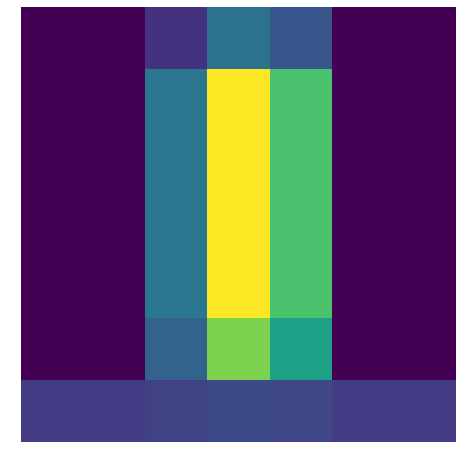

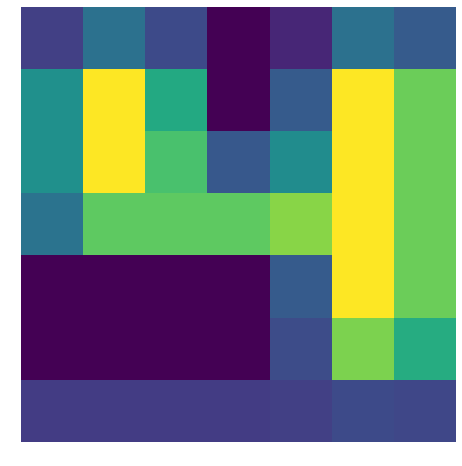

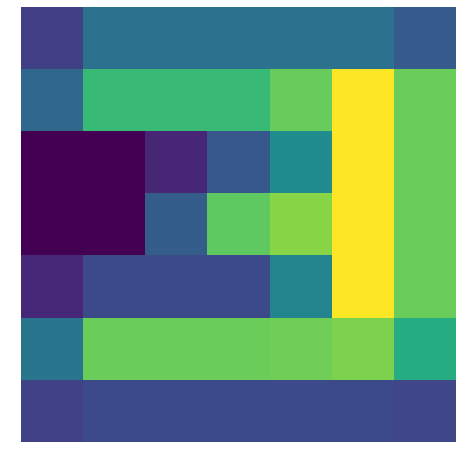

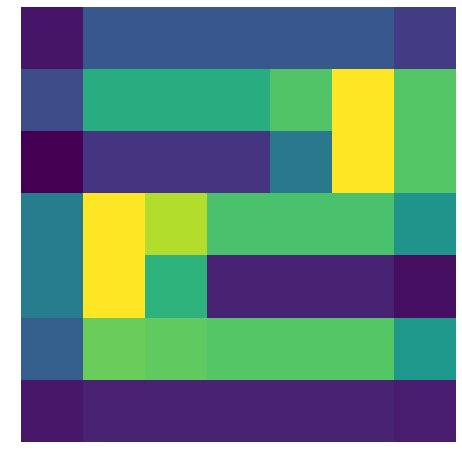

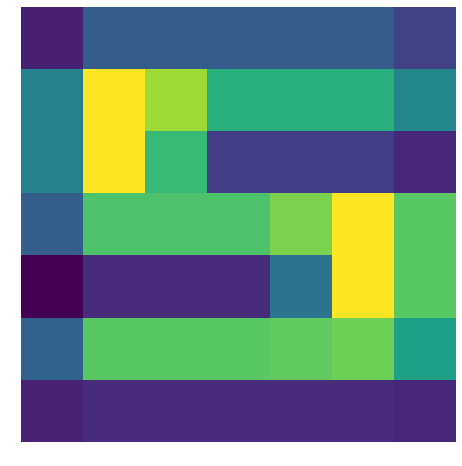

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

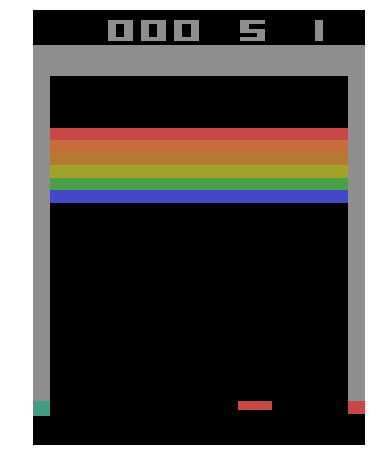

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

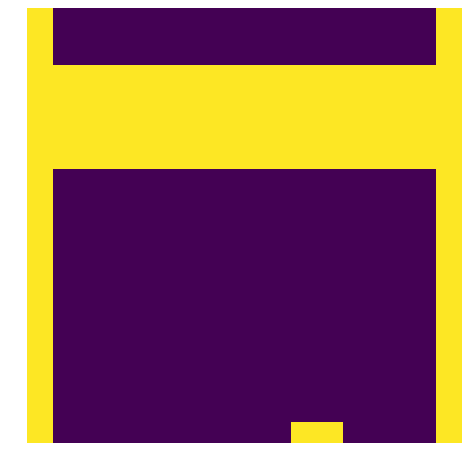

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.zeros(shape=(1000000,84,84,4)),\
                        "reward" : np.zeros(shape=(1000000,)),\
                        "action": np.zeros(shape=(1000000,)), \
                        "Q": np.zeros(shape=(1000000,4))}

In [ ]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 10000
episode_scores = []
total_frames = 0
epsilon = 1.0
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    while game: 
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = 0
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        
        if done:
            total_frames += episode_history["state"].shape[0]
            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.max(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
            
            full_episode_history["state"][total_frames - episode_history["state"].shape[0]: total_frames,:,:,:] = episode_history["state"]
            full_episode_history["reward"][total_frames - episode_history["state"].shape[0]: total_frames] = episode_history["reward"]
            full_episode_history["action"][total_frames - episode_history["state"].shape[0]: total_frames] = episode_history["action"]
            full_episode_history["Q"][total_frames - episode_history["state"].shape[0]: total_frames,:] = episode_history["Q"]

            print("Training the model from a random batch...")

            rand = np.random.choice(range(total_frames), size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 5, batch_size=8, verbose=0)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            
            
            m = -9e-7
            epsilon = round(m*total_frames +1,3)
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
                             
        else:
            pass
            
         

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 2 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 3 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 4 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 5 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 6 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 7 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 8 of 10000...

Training the mod

Total game score was: 3
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 62 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 63 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 64 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 65 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 66 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 67 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 68 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome 

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 123 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 124 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 125 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 126 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 127 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 128 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 129 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 183 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 184 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 185 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 186 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 187 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 188 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 189 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.986

Welcome to AI Breakout!
Starting Game 243 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 244 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 245 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 246 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 247 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 248 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 249 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 303 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 304 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 305 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 306 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 307 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 308 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 309 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 363 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 364 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 365 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 366 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 367 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 368 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 369 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 423 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 424 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 425 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 426 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 427 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 428 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 429 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 483 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 484 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 485 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 486 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 487 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.97

Welcome to AI Breakout!
Starting Game 488 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.97

Welcome to AI Breakout!
Starting Game 489 of 10000...

Training the model from a random batch...
T

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 543 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 544 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 545 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 546 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 547 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 548 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 549 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.964

Welcome to AI Breakout!
Starting Game 603 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 604 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 605 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 606 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 607 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 608 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 609 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 663 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 664 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 665 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 666 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 667 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.959

Welcome to AI Breakout!
Starting Game 668 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.959

Welcome to AI Breakout!
Starting Game 669 of 10000...

Training the model from a random batch...
Tota

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 723 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 724 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 725 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 726 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 727 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 728 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 729 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 783 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 784 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 785 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 786 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 787 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 788 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.952

Welcome to AI Breakout!
Starting Game 789 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 843 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 844 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 845 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 846 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 847 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 848 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 849 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 903 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 904 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 905 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 906 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 907 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 908 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 909 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.943

Welcome to AI Breakout!
Starting Game 963 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.943

Welcome to AI Breakout!
Starting Game 964 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.943

Welcome to AI Breakout!
Starting Game 965 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.943

Welcome to AI Breakout!
Starting Game 966 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.943

Welcome to AI Breakout!
Starting Game 967 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 968 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 969 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1023 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1024 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1025 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1026 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1027 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1028 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.939

Welcome to AI Breakout!
Starting Game 1029 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.936

Welcome to AI Breakout!
Starting Game 1083 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.936

Welcome to AI Breakout!
Starting Game 1084 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.936

Welcome to AI Breakout!
Starting Game 1085 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.936

Welcome to AI Breakout!
Starting Game 1086 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.936

Welcome to AI Breakout!
Starting Game 1087 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1088 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1089 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1143 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1144 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1145 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1146 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1147 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1148 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.932

Welcome to AI Breakout!
Starting Game 1149 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.929

Welcome to AI Breakout!
Starting Game 1203 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.929

Welcome to AI Breakout!
Starting Game 1204 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.929

Welcome to AI Breakout!
Starting Game 1205 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1206 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1207 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1208 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1209 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1263 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1264 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1265 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1266 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1267 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1268 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.925

Welcome to AI Breakout!
Starting Game 1269 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1323 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1324 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1325 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1326 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1327 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1328 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1329 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1383 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1384 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1385 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1386 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1387 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.918

Welcome to AI Breakout!
Starting Game 1388 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1389 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1443 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1444 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1445 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1446 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1447 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1448 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1449 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1503 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1504 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1505 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1506 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1507 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1508 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.911

Welcome to AI Breakout!
Starting Game 1509 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1563 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1564 of 10000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1565 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1566 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1567 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1568 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1569 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.904

Welcome to AI Breakout!
Starting Game 1623 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.904

Welcome to AI Breakout!
Starting Game 1624 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.904

Welcome to AI Breakout!
Starting Game 1625 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.904

Welcome to AI Breakout!
Starting Game 1626 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.904

Welcome to AI Breakout!
Starting Game 1627 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1628 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1629 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1683 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1684 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1685 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1686 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1687 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1688 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1689 of 10000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.897

Welcome to AI Breakout!
Starting Game 1743 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.897

Welcome to AI Breakout!
Starting Game 1744 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1745 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1746 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1747 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1748 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1749 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1803 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1804 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1805 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1806 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1807 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1808 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.892

Welcome to AI Breakout!
Starting Game 1809 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1863 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1864 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1865 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1866 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1867 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1868 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1869 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1923 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1924 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1925 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1926 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.885

Welcome to AI Breakout!
Starting Game 1927 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.885

Welcome to AI Breakout!
Starting Game 1928 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.885

Welcome to AI Breakout!
Starting Game 1929 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1983 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1984 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1985 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1986 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1987 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1988 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1989 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2043 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2044 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2045 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2046 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2047 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2048 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2049 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2103 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2104 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2105 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2106 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2107 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2108 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2109 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2163 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2164 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2165 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2166 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.871

Welcome to AI Breakout!
Starting Game 2167 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.871

Welcome to AI Breakout!
Starting Game 2168 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.871

Welcome to AI Breakout!
Starting Game 2169 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2223 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2224 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2225 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2226 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2227 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2228 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2229 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2283 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2284 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2285 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2286 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2287 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2288 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2289 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2343 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2344 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2345 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2346 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.86

Welcome to AI Breakout!
Starting Game 2347 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.86

Welcome to AI Breakout!
Starting Game 2348 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.86

Welcome to AI Breakout!
Starting Game 2349 of 10000...

Training the model from a random batc

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2403 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2404 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2405 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2406 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2407 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2408 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2409 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2463 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2464 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2465 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2466 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2467 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.854

Welcome to AI Breakout!
Starting Game 2468 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2469 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2523 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2524 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2525 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2526 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2527 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2528 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2529 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.847

Welcome to AI Breakout!
Starting Game 2583 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.847

Welcome to AI Breakout!
Starting Game 2584 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.847

Welcome to AI Breakout!
Starting Game 2585 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.847

Welcome to AI Breakout!
Starting Game 2586 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.847

Welcome to AI Breakout!
Starting Game 2587 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2588 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2589 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2643 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2644 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2645 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2646 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2647 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2648 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.843

Welcome to AI Breakout!
Starting Game 2649 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.84

Welcome to AI Breakout!
Starting Game 2703 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2704 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2705 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2706 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2707 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2708 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2709 of 10000...

Training the model from a random ba

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2763 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2764 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2765 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2766 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2767 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2768 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2769 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2823 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2824 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2825 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2826 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2827 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2828 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2829 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2883 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2884 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2885 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2886 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2887 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.829

Welcome to AI Breakout!
Starting Game 2888 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2889 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2943 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2944 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2945 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2946 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2947 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2948 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2949 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.822

Welcome to AI Breakout!
Starting Game 3003 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.822

Welcome to AI Breakout!
Starting Game 3004 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.822

Welcome to AI Breakout!
Starting Game 3005 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.822

Welcome to AI Breakout!
Starting Game 3006 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.822

Welcome to AI Breakout!
Starting Game 3007 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3008 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3009 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3063 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3064 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3065 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3066 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3067 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3068 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.818

Welcome to AI Breakout!
Starting Game 3069 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.815

Welcome to AI Breakout!
Starting Game 3123 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.815

Welcome to AI Breakout!
Starting Game 3124 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.815

Welcome to AI Breakout!
Starting Game 3125 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3126 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3127 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3128 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3129 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 8
Epsilon: 0.811

Welcome to AI Breakout!
Starting Game 3183 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.811

Welcome to AI Breakout!
Starting Game 3184 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.811

Welcome to AI Breakout!
Starting Game 3185 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.811

Welcome to AI Breakout!
Starting Game 3186 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.811

Welcome to AI Breakout!
Starting Game 3187 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3188 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3189 of 10000...

Training the model from a random bat

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3243 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3244 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3245 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3246 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3247 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3248 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3249 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.804

Welcome to AI Breakout!
Starting Game 3303 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.804

Welcome to AI Breakout!
Starting Game 3304 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3305 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3306 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3307 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3308 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3309 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3363 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3364 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3365 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3366 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3367 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3368 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3369 of 10000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.797

Welcome to AI Breakout!
Starting Game 3423 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.797

Welcome to AI Breakout!
Starting Game 3424 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3425 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3426 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3427 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3428 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3429 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3483 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3484 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3485 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3486 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3487 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3488 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3489 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.79

Welcome to AI Breakout!
Starting Game 3543 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.79

Welcome to AI Breakout!
Starting Game 3544 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.79

Welcome to AI Breakout!
Starting Game 3545 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.79

Welcome to AI Breakout!
Starting Game 3546 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3547 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3548 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3549 of 10000...

Training the model from a random batch

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3603 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3604 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3605 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3606 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3607 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3608 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.786

Welcome to AI Breakout!
Starting Game 3609 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3663 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3664 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3665 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3666 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3667 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3668 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3669 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.779

Welcome to AI Breakout!
Starting Game 3723 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.779

Welcome to AI Breakout!
Starting Game 3724 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.779

Welcome to AI Breakout!
Starting Game 3725 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.779

Welcome to AI Breakout!
Starting Game 3726 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.779

Welcome to AI Breakout!
Starting Game 3727 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3728 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3729 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3783 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3784 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3785 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3786 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3787 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3788 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.775

Welcome to AI Breakout!
Starting Game 3789 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3843 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3844 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3845 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3846 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3847 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3848 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.772

Welcome to AI Breakout!
Starting Game 3849 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3903 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3904 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3905 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3906 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3907 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3908 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.768

Welcome to AI Breakout!
Starting Game 3909 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.765

Welcome to AI Breakout!
Starting Game 3963 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.765

Welcome to AI Breakout!
Starting Game 3964 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.765

Welcome to AI Breakout!
Starting Game 3965 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3966 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3967 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3968 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3969 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4023 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4024 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4025 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4026 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4027 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4028 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.761

Welcome to AI Breakout!
Starting Game 4029 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4083 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4084 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4085 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4086 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4087 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4088 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4089 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.754

Welcome to AI Breakout!
Starting Game 4143 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.754

Welcome to AI Breakout!
Starting Game 4144 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4145 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4146 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4147 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4148 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4149 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4203 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4204 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4205 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4206 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4207 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4208 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.75

Welcome to AI Breakout!
Starting Game 4209 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4263 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4264 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4265 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4266 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4267 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4268 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.747

Welcome to AI Breakout!
Starting Game 4269 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4323 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4324 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4325 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4326 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4327 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4328 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.743

Welcome to AI Breakout!
Starting Game 4329 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4383 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4384 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4385 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4386 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4387 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4388 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.74

Welcome to AI Breakout!
Starting Game 4389 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4443 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4444 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4445 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4446 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4447 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4448 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.736

Welcome to AI Breakout!
Starting Game 4449 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4503 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4504 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4505 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4506 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4507 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4508 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.733

Welcome to AI Breakout!
Starting Game 4509 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.73

Welcome to AI Breakout!
Starting Game 4563 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4564 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4565 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4566 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4567 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4568 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.729

Welcome to AI Breakout!
Starting Game 4569 of 10000...

Training the model from a random ba

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4623 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4624 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4625 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4626 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4627 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4628 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.726

Welcome to AI Breakout!
Starting Game 4629 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4683 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4684 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4685 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4686 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4687 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4688 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.722

Welcome to AI Breakout!
Starting Game 4689 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4743 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4744 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4745 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4746 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4747 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.719

Welcome to AI Breakout!
Starting Game 4748 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.718

Welcome to AI Breakout!
Starting Game 4749 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.716

Welcome to AI Breakout!
Starting Game 4803 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4804 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4805 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4806 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4807 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4808 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.715

Welcome to AI Breakout!
Starting Game 4809 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4863 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4864 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4865 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4866 of 10000...

Training the model from a random batch...
Total game score was: 8
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4867 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.712

Welcome to AI Breakout!
Starting Game 4868 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.711

Welcome to AI Breakout!
Starting Game 4869 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4923 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4924 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4925 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4926 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4927 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4928 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.708

Welcome to AI Breakout!
Starting Game 4929 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.705

Welcome to AI Breakout!
Starting Game 4983 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.705

Welcome to AI Breakout!
Starting Game 4984 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.705

Welcome to AI Breakout!
Starting Game 4985 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4986 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4987 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4988 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4989 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5043 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5044 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5045 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5046 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5047 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5048 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.701

Welcome to AI Breakout!
Starting Game 5049 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5103 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5104 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5105 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5106 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5107 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5108 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.697

Welcome to AI Breakout!
Starting Game 5109 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5163 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5164 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5165 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5166 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5167 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5168 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.694

Welcome to AI Breakout!
Starting Game 5169 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5223 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5224 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5225 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5226 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5227 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5228 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.69

Welcome to AI Breakout!
Starting Game 5229 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5283 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5284 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5285 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5286 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5287 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5288 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.687

Welcome to AI Breakout!
Starting Game 5289 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5343 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5344 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5345 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5346 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5347 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5348 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.683

Welcome to AI Breakout!
Starting Game 5349 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.68

Welcome to AI Breakout!
Starting Game 5403 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.68

Welcome to AI Breakout!
Starting Game 5404 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.68

Welcome to AI Breakout!
Starting Game 5405 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.68

Welcome to AI Breakout!
Starting Game 5406 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.68

Welcome to AI Breakout!
Starting Game 5407 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.679

Welcome to AI Breakout!
Starting Game 5408 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.679

Welcome to AI Breakout!
Starting Game 5409 of 10000...

Training the model from a random batch.

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.676

Welcome to AI Breakout!
Starting Game 5463 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.676

Welcome to AI Breakout!
Starting Game 5464 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.676

Welcome to AI Breakout!
Starting Game 5465 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.676

Welcome to AI Breakout!
Starting Game 5466 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.676

Welcome to AI Breakout!
Starting Game 5467 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.675

Welcome to AI Breakout!
Starting Game 5468 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.675

Welcome to AI Breakout!
Starting Game 5469 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.673

Welcome to AI Breakout!
Starting Game 5523 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5524 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5525 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5526 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5527 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5528 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.672

Welcome to AI Breakout!
Starting Game 5529 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5583 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5584 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5585 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5586 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5587 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.669

Welcome to AI Breakout!
Starting Game 5588 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.668

Welcome to AI Breakout!
Starting Game 5589 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5643 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5644 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5645 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5646 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5647 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5648 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.665

Welcome to AI Breakout!
Starting Game 5649 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5703 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5704 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5705 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5706 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5707 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.662

Welcome to AI Breakout!
Starting Game 5708 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.661

Welcome to AI Breakout!
Starting Game 5709 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5763 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5764 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5765 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5766 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5767 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5768 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.658

Welcome to AI Breakout!
Starting Game 5769 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5823 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5824 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5825 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5826 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5827 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5828 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.655

Welcome to AI Breakout!
Starting Game 5829 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.652

Welcome to AI Breakout!
Starting Game 5883 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5884 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5885 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5886 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5887 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5888 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.651

Welcome to AI Breakout!
Starting Game 5889 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5943 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5944 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5945 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5946 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5947 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5948 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.648

Welcome to AI Breakout!
Starting Game 5949 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6003 of 10000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6004 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6005 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6006 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6007 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6008 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.644

Welcome to AI Breakout!
Starting Game 6009 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.641

Welcome to AI Breakout!
Starting Game 6063 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.641

Welcome to AI Breakout!
Starting Game 6064 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.64

Welcome to AI Breakout!
Starting Game 6065 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.64

Welcome to AI Breakout!
Starting Game 6066 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.64

Welcome to AI Breakout!
Starting Game 6067 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.64

Welcome to AI Breakout!
Starting Game 6068 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.64

Welcome to AI Breakout!
Starting Game 6069 of 10000...

Training the model from a random batch.

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6123 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6124 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6125 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6126 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6127 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6128 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.637

Welcome to AI Breakout!
Starting Game 6129 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.634

Welcome to AI Breakout!
Starting Game 6183 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.634

Welcome to AI Breakout!
Starting Game 6184 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.633

Welcome to AI Breakout!
Starting Game 6185 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.633

Welcome to AI Breakout!
Starting Game 6186 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.633

Welcome to AI Breakout!
Starting Game 6187 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.633

Welcome to AI Breakout!
Starting Game 6188 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.633

Welcome to AI Breakout!
Starting Game 6189 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6243 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6244 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6245 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6246 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6247 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6248 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.63

Welcome to AI Breakout!
Starting Game 6249 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6303 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6304 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6305 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6306 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6307 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6308 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.626

Welcome to AI Breakout!
Starting Game 6309 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.623

Welcome to AI Breakout!
Starting Game 6363 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6364 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6365 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6366 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6367 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6368 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.622

Welcome to AI Breakout!
Starting Game 6369 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6423 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6424 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6425 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6426 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6427 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6428 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.619

Welcome to AI Breakout!
Starting Game 6429 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6483 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6484 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6485 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6486 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6487 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6488 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.615

Welcome to AI Breakout!
Starting Game 6489 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6543 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6544 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6545 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6546 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6547 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6548 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.612

Welcome to AI Breakout!
Starting Game 6549 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6603 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6604 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6605 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6606 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6607 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6608 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.608

Welcome to AI Breakout!
Starting Game 6609 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.605

Welcome to AI Breakout!
Starting Game 6663 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.605

Welcome to AI Breakout!
Starting Game 6664 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.605

Welcome to AI Breakout!
Starting Game 6665 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.605

Welcome to AI Breakout!
Starting Game 6666 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.605

Welcome to AI Breakout!
Starting Game 6667 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.604

Welcome to AI Breakout!
Starting Game 6668 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.604

Welcome to AI Breakout!
Starting Game 6669 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6723 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6724 of 10000...

Training the model from a random batch...
Total game score was: 9
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6725 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6726 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6727 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6728 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.601

Welcome to AI Breakout!
Starting Game 6729 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.598

Welcome to AI Breakout!
Starting Game 6783 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.598

Welcome to AI Breakout!
Starting Game 6784 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.598

Welcome to AI Breakout!
Starting Game 6785 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.598

Welcome to AI Breakout!
Starting Game 6786 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.597

Welcome to AI Breakout!
Starting Game 6787 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.597

Welcome to AI Breakout!
Starting Game 6788 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.597

Welcome to AI Breakout!
Starting Game 6789 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6843 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6844 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6845 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6846 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6847 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6848 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.594

Welcome to AI Breakout!
Starting Game 6849 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.591

Welcome to AI Breakout!
Starting Game 6903 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.591

Welcome to AI Breakout!
Starting Game 6904 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.59

Welcome to AI Breakout!
Starting Game 6905 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.59

Welcome to AI Breakout!
Starting Game 6906 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.59

Welcome to AI Breakout!
Starting Game 6907 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.59

Welcome to AI Breakout!
Starting Game 6908 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.59

Welcome to AI Breakout!
Starting Game 6909 of 10000...

Training the model from a random batch.

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6963 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6964 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6965 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6966 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6967 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6968 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.587

Welcome to AI Breakout!
Starting Game 6969 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.584

Welcome to AI Breakout!
Starting Game 7023 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7024 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7025 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7026 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7027 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7028 of 10000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.583

Welcome to AI Breakout!
Starting Game 7029 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7083 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7084 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7085 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7086 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7087 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7088 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.58

Welcome to AI Breakout!
Starting Game 7089 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.577

Welcome to AI Breakout!
Starting Game 7143 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.577

Welcome to AI Breakout!
Starting Game 7144 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.576

Welcome to AI Breakout!
Starting Game 7145 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.576

Welcome to AI Breakout!
Starting Game 7146 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.576

Welcome to AI Breakout!
Starting Game 7147 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.576

Welcome to AI Breakout!
Starting Game 7148 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.576

Welcome to AI Breakout!
Starting Game 7149 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.573

Welcome to AI Breakout!
Starting Game 7203 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.573

Welcome to AI Breakout!
Starting Game 7204 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.572

Welcome to AI Breakout!
Starting Game 7205 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.572

Welcome to AI Breakout!
Starting Game 7206 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.572

Welcome to AI Breakout!
Starting Game 7207 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.572

Welcome to AI Breakout!
Starting Game 7208 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.572

Welcome to AI Breakout!
Starting Game 7209 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7263 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7264 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7265 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7266 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7267 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.569

Welcome to AI Breakout!
Starting Game 7268 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.568

Welcome to AI Breakout!
Starting Game 7269 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7323 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7324 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7325 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7326 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7327 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7328 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.565

Welcome to AI Breakout!
Starting Game 7329 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7383 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7384 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7385 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7386 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7387 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7388 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.561

Welcome to AI Breakout!
Starting Game 7389 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7443 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7444 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7445 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7446 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7447 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7448 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.558

Welcome to AI Breakout!
Starting Game 7449 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7503 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7504 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7505 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7506 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7507 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7508 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.554

Welcome to AI Breakout!
Starting Game 7509 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7563 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7564 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7565 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7566 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7567 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7568 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.551

Welcome to AI Breakout!
Starting Game 7569 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7623 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7624 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7625 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7626 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7627 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7628 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.547

Welcome to AI Breakout!
Starting Game 7629 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7683 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7684 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7685 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7686 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7687 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7688 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.544

Welcome to AI Breakout!
Starting Game 7689 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7743 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7744 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7745 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7746 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7747 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7748 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.54

Welcome to AI Breakout!
Starting Game 7749 of 10000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.537

Welcome to AI Breakout!
Starting Game 7803 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.537

Welcome to AI Breakout!
Starting Game 7804 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.537

Welcome to AI Breakout!
Starting Game 7805 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.536

Welcome to AI Breakout!
Starting Game 7806 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.536

Welcome to AI Breakout!
Starting Game 7807 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.536

Welcome to AI Breakout!
Starting Game 7808 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.536

Welcome to AI Breakout!
Starting Game 7809 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7863 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7864 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7865 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7866 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7867 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7868 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.533

Welcome to AI Breakout!
Starting Game 7869 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7923 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7924 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7925 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7926 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7927 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7928 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.529

Welcome to AI Breakout!
Starting Game 7929 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.526

Welcome to AI Breakout!
Starting Game 7983 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.526

Welcome to AI Breakout!
Starting Game 7984 of 10000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.526

Welcome to AI Breakout!
Starting Game 7985 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.526

Welcome to AI Breakout!
Starting Game 7986 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.525

Welcome to AI Breakout!
Starting Game 7987 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.525

Welcome to AI Breakout!
Starting Game 7988 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.525

Welcome to AI Breakout!
Starting Game 7989 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8043 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8044 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8045 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8046 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8047 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8048 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.522

Welcome to AI Breakout!
Starting Game 8049 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.519

Welcome to AI Breakout!
Starting Game 8103 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.519

Welcome to AI Breakout!
Starting Game 8104 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.519

Welcome to AI Breakout!
Starting Game 8105 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.519

Welcome to AI Breakout!
Starting Game 8106 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.518

Welcome to AI Breakout!
Starting Game 8107 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.518

Welcome to AI Breakout!
Starting Game 8108 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.518

Welcome to AI Breakout!
Starting Game 8109 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8163 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8164 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8165 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8166 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8167 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8168 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.515

Welcome to AI Breakout!
Starting Game 8169 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.512

Welcome to AI Breakout!
Starting Game 8223 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.512

Welcome to AI Breakout!
Starting Game 8224 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.511

Welcome to AI Breakout!
Starting Game 8225 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.511

Welcome to AI Breakout!
Starting Game 8226 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.511

Welcome to AI Breakout!
Starting Game 8227 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.511

Welcome to AI Breakout!
Starting Game 8228 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.511

Welcome to AI Breakout!
Starting Game 8229 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8283 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8284 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8285 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8286 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8287 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8288 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.508

Welcome to AI Breakout!
Starting Game 8289 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.505

Welcome to AI Breakout!
Starting Game 8343 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.505

Welcome to AI Breakout!
Starting Game 8344 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.505

Welcome to AI Breakout!
Starting Game 8345 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.505

Welcome to AI Breakout!
Starting Game 8346 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.505

Welcome to AI Breakout!
Starting Game 8347 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.504

Welcome to AI Breakout!
Starting Game 8348 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.504

Welcome to AI Breakout!
Starting Game 8349 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8403 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8404 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8405 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8406 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8407 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8408 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.501

Welcome to AI Breakout!
Starting Game 8409 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8463 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8464 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8465 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8466 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8467 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8468 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.497

Welcome to AI Breakout!
Starting Game 8469 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8523 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8524 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8525 of 10000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8526 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8527 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.494

Welcome to AI Breakout!
Starting Game 8528 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.493

Welcome to AI Breakout!
Starting Game 8529 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.491

Welcome to AI Breakout!
Starting Game 8583 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8584 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8585 of 10000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8586 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8587 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8588 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.49

Welcome to AI Breakout!
Starting Game 8589 of 10000...

Training the model from a random batch..

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8643 of 10000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8644 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8645 of 10000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8646 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8647 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8648 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.487

Welcome to AI Breakout!
Starting Game 8649 of 10000...

Training the model from a random b

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8703 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8704 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8705 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8706 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8707 of 10000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8708 of 10000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.483

Welcome to AI Breakout!
Starting Game 8709 of 10000...

Training the model from a random b

In [ ]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

In [ ]:
print(episode_history["reward"][:])

In [ ]:
print(episode_history["action"])

In [ ]:
print(episode_history["Q"][10])

In [ ]:
model.predict(np.expand_dims(episode_history["state"][10],0))

In [ ]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [ ]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [ ]:
mod = load_model("breakout-atari-rl.h5")

In [ ]:

env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 20
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    observation_batch = []
    while game:
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                action = np.argmax(mod.predict(states))
                print(action)

                if np.array_equal(states[0][:84,:84,0], states[0][:84,:84,3]):
                    action = 1
                    print("Yes")
                else:
                    pass
                
                observation_batch = []                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        observation_batch.append(observation)
        
        if (frame % 4 == 0):
            states = np.concatenate([i for i in observation_batch], axis=-1)
            states = np.expand_dims(states,0)

        sum += reward
        frame += 1
        time.sleep(0.03)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        

